# Synthetic Natural Image Patches

An example application of the `circle_bundles` pipeline to a synthetic dataset of
high-contrast $n \times n$ optical image patches sampled from a known model with
the topology of a Klein bottle embedded in $\mathbb{R}^{n^2}$
(see {cite}`CarlssonIshkhanovDeSilvaZomorodian2008NaturalImages` for details).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

from dreimac import CircularCoords

import circle_bundles as cb

Generate the dataset and treat patches as vectors in $\mathbb{R}^{n^{2}}$:

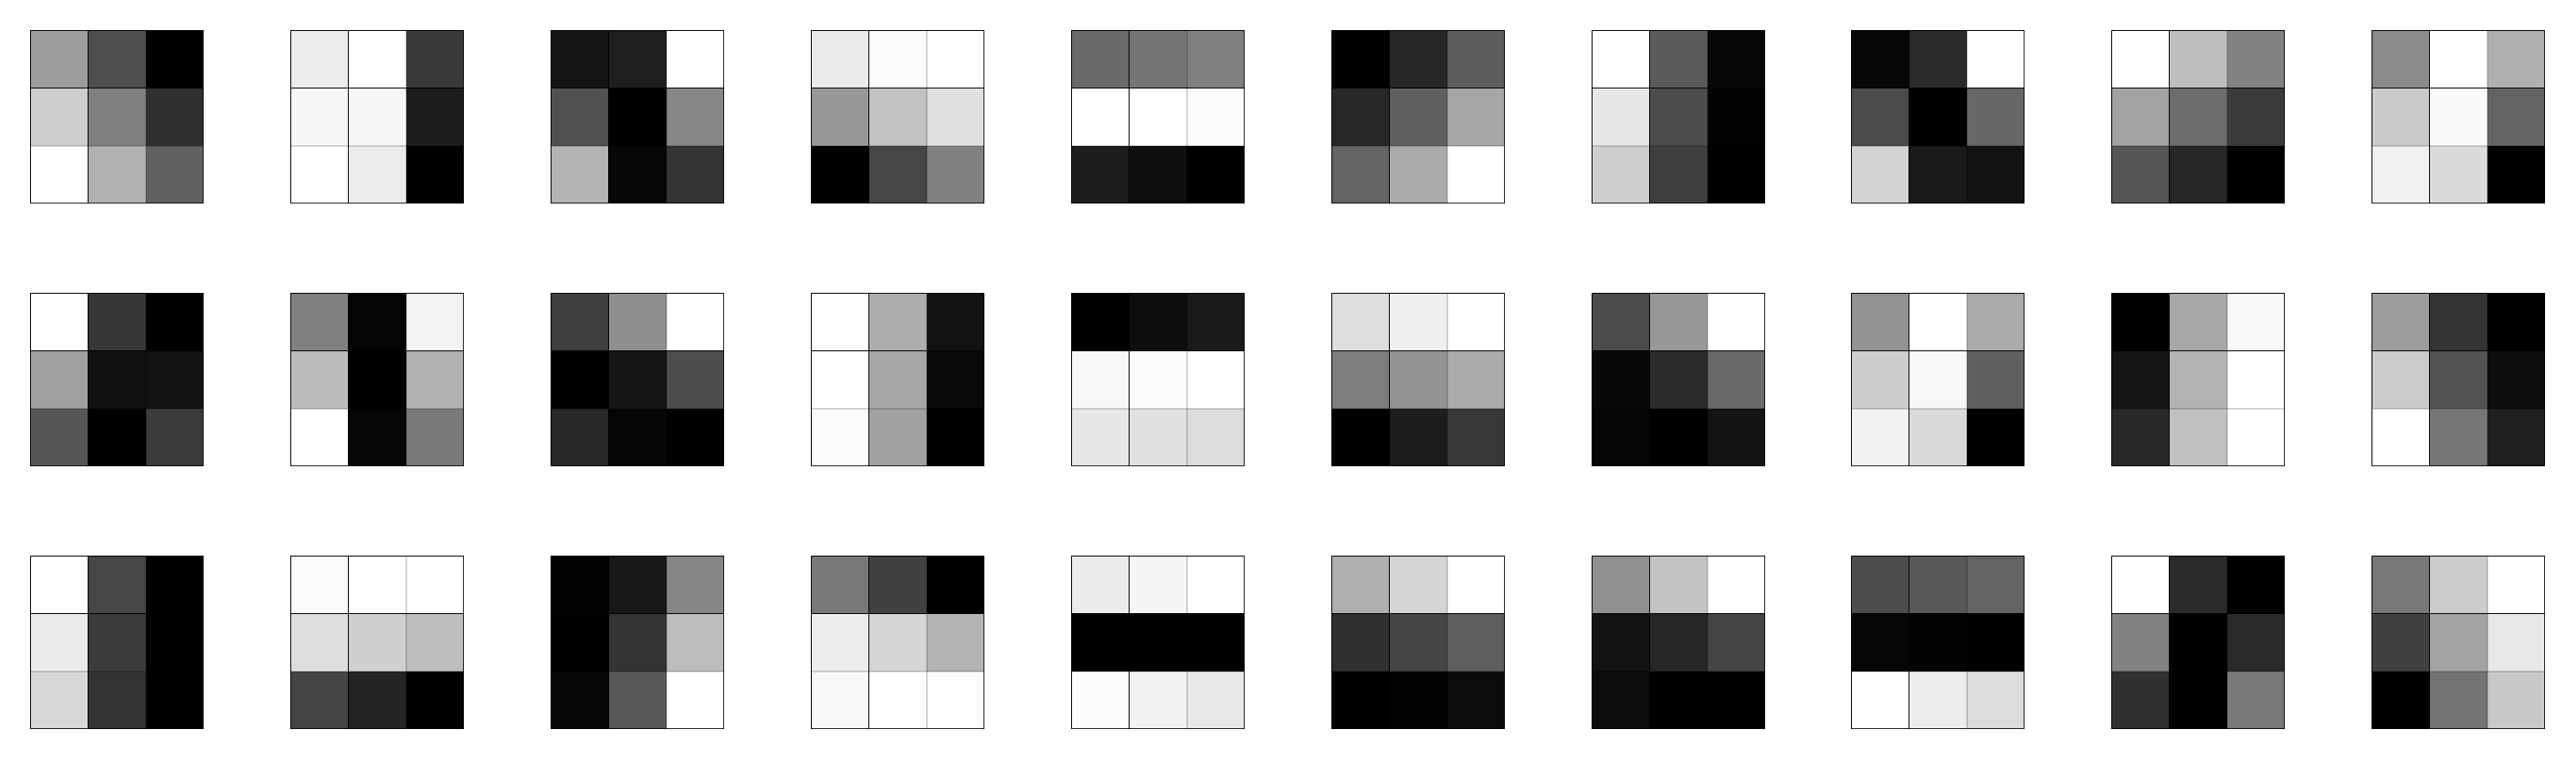

In [2]:
n_patches = 5000  
n = 3   #Choose a patch size

rng = np.random.default_rng(0)
data = cb.sample_nat_img_kb(n_patches, n = n, rng = rng)[0]  

#Create a patch visualizer function
patch_vis = cb.make_patch_visualizer()

#View a small sample of the data
n_samples = 30

fig = cb.show_data_vis(
    data, 
    patch_vis, 
    max_samples = n_samples)
plt.show()

Show a PCA visualization of the dataset:

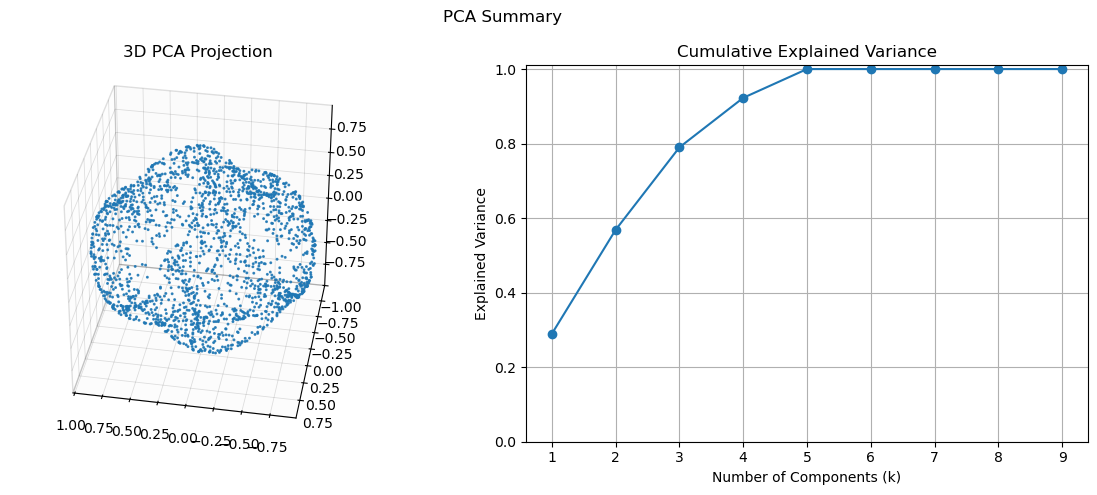

In [3]:
cb.show_pca(data, size = 0.2, elev = 35, azim = 100)

Recall that for a Klein bottle $K$, one has $H^{1}(K;\mathbb{Z})\cong \mathbb{Z}\oplus\mathbb{Z}_{2}$ and $H^{2}(K;\mathbb{Z})=0$. Compute persistence diagrams over $\mathbb{Z}_{2}$ and $\mathbb{Z}_{3}$ for a sample of the dataset: 


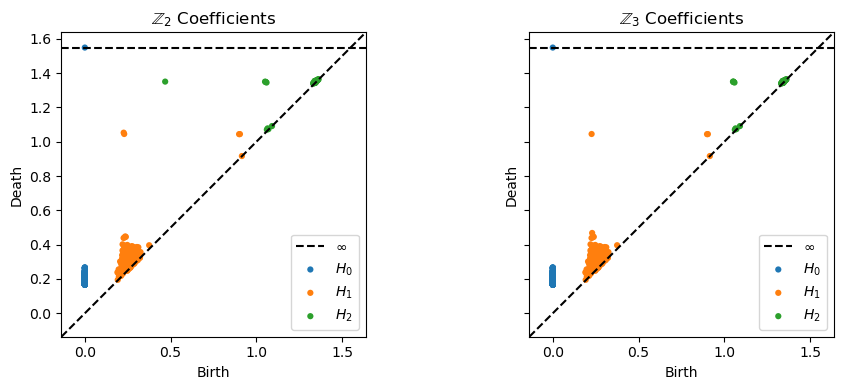

In [4]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title=r"$\mathbb{Z}_{2}$ Coefficients")
plot_diagrams(dgms_3, ax=axes[1], title=r"$\mathbb{Z}_{3}$ Coefficients")

plt.tight_layout()
plt.show()


As expected, the $\mathbb{Z}_{2}$ diagram shows two 1-dimensional persistent classes and one 2-dimensional persistent class, but the $\mathbb{Z}_{3}$ diagram shows a single 1-dimensional persistent class and no 2-dimensional persistent classes. 

Use the DREiMac circular coordinates algorithm to construct a map to $\mathbb{S}^{1}$ which captures the circular topological feature represented by the 1-dimensional $\mathbb{Z}_{3}$ persistent class:

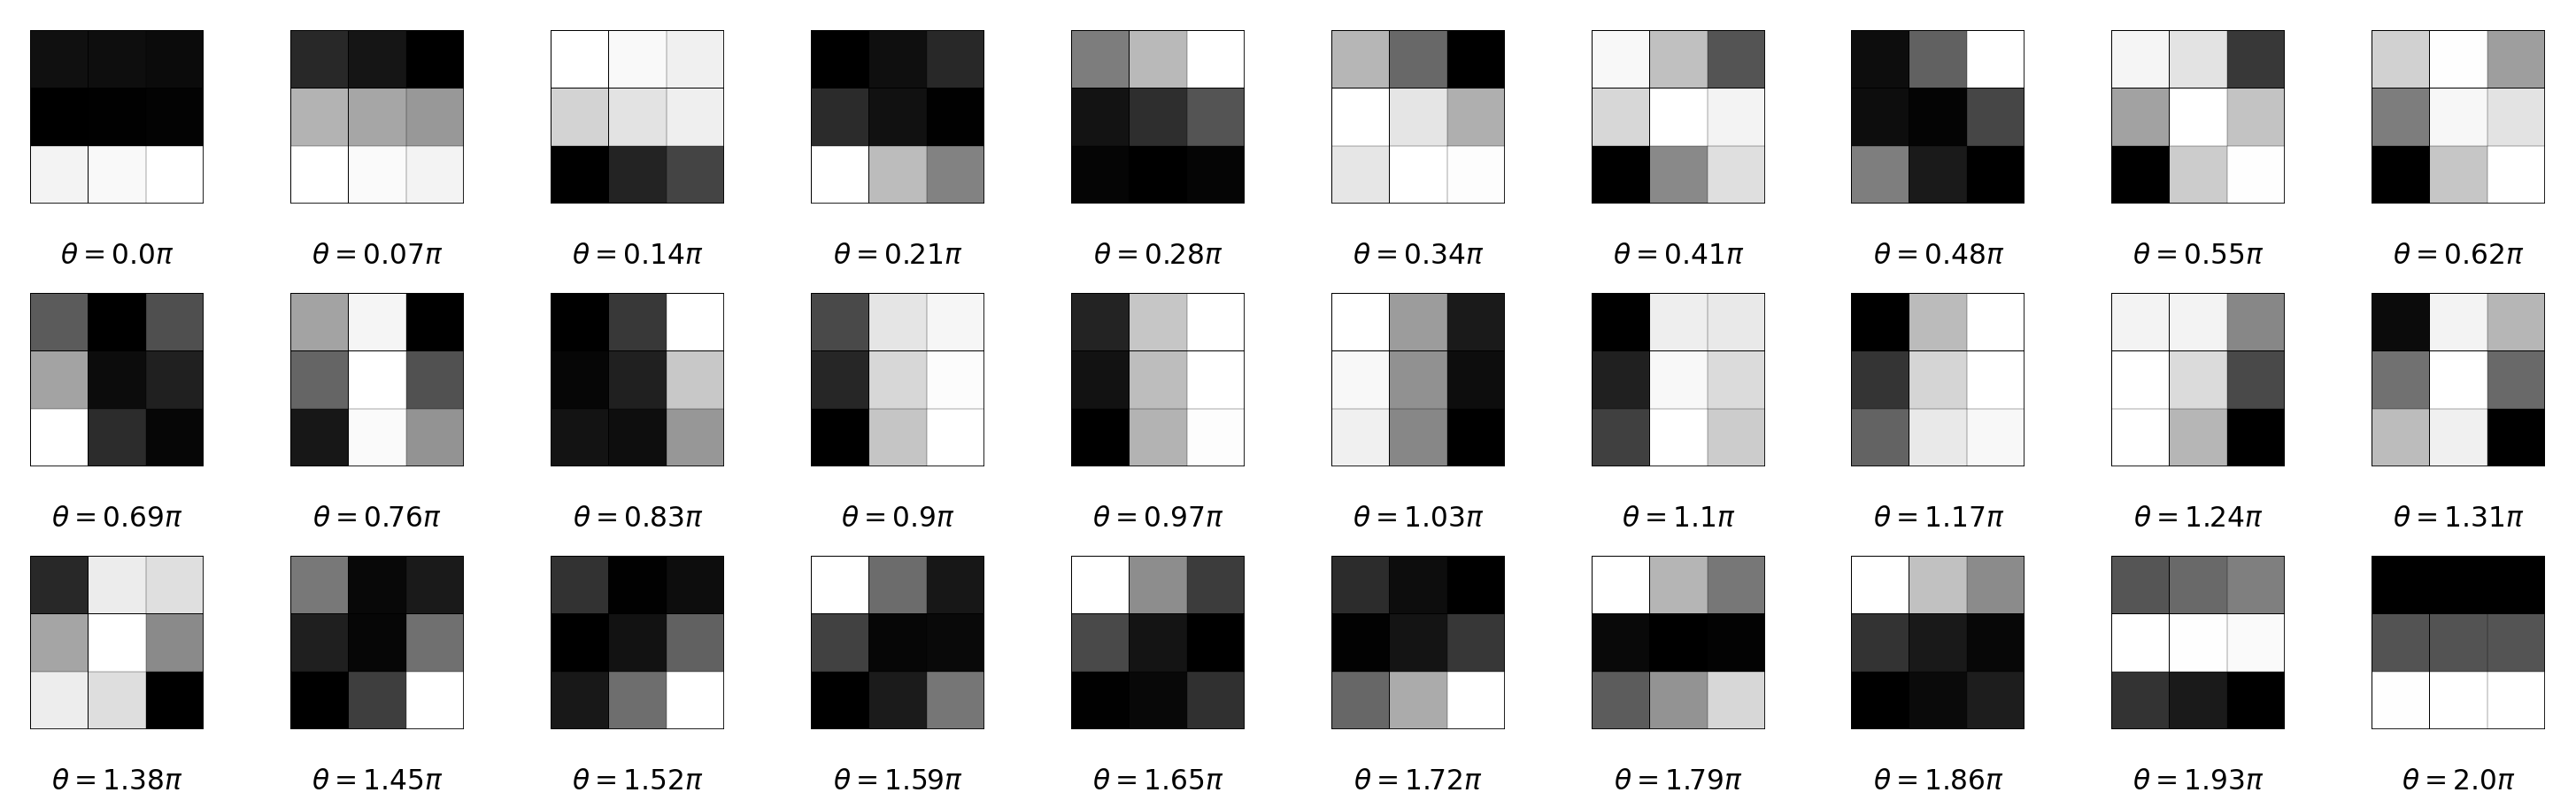

In [3]:
cc = CircularCoords(data, prime = 3, n_landmarks = 500)
base_angles = cc.get_coordinates()


#View a small random sample of the dataset arranged by circular coordinate:
n_samples = 30

label_func = [fr"$\theta = {np.round(angle/np.pi, 2)}$" + r"$\pi$" for angle in base_angles]

fig = cb.show_data_vis(
    data, 
    patch_vis, 
    label_func = label_func, 
    angles = base_angles, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Observe that the assigned circular coordinates roughly correspond to the $\textit{predominant gradient axes}$ of the patches.

Establish an open cover of $\mathbb{S}^{1} = \mathbb{R}/(2\pi\mathbb{Z})$ by metric balls around equally-spaced landmarks:

In [4]:
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi,n_landmarks, endpoint= False).reshape(-1,1)
overlap = 1.4

radius = overlap* np.pi/n_landmarks

cover = cb.get_metric_ball_cover(base_angles.reshape(-1,1), 
                                 landmarks, 
                                 radius = radius, 
                                 metric = cb.S1AngleMetric())


Show PCA projections of the data in each $\pi^{-1}(U_{j})$:

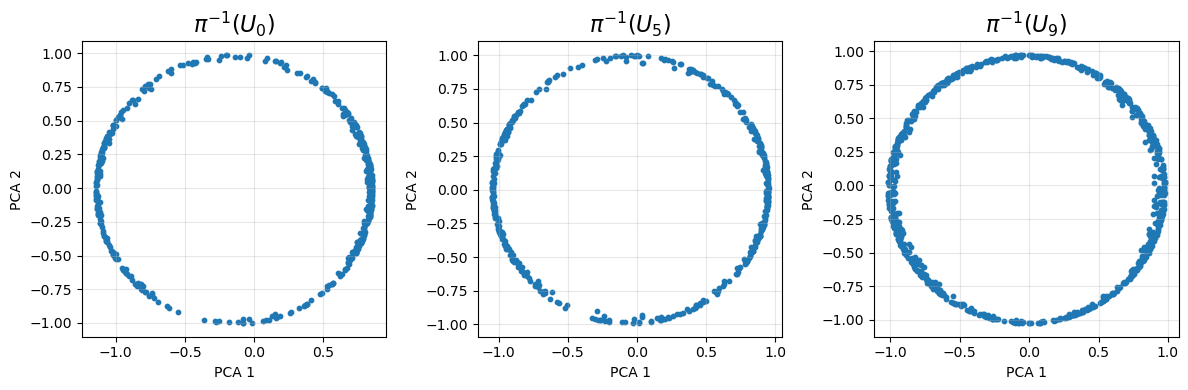

In [8]:
fig, axes = cb.get_local_pca(data, 
                      cover.U,
                      to_view = [0,5,9],
                     )
plt.show()

Observe that each $\pi^{-1}(U_{j})$ appears to be concentrated around the unit circle in a plane, supporting the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{S}^{1}$. Up to isomorphism, the only circle bundles over $\mathbb{S}^{1}$ are the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by the orientation class $w_{1}$.

Construct a bundle object. Use $\text{PCA}_{2}$ to construct local circular coordinate systems, then compute characteristic classes:

In [5]:
bundle = cb.Bundle(X = data, U = cover.U)
triv_result = bundle.get_local_trivs()
class_result = bundle.get_classes(show_classes = True, show_persistence = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The results above confirm the non-trivial global structure, so a global trivialization is not possible here. On the other hand, as indicated by the class persistence table, the $w_{1}$ class representative restricts to a coboundary once an edge is removed from the nerve of the cover (indeed, any cocycle is a coboundary on this subcomplex). 

Remove an edge from the nerve of the open cover (corresponding to the set intersection with the poorest Procrustes alignment quality), and compute coordinates which reflect this cut:  

In [6]:
global_triv_result = bundle.get_global_trivialization(pou = cover.pou)

Show a visualization of $\mathcal{N}(\mathcal{U})$ with edges decorated by the values of the computed orientation cocycle representative (shown in blue).  The 'weight' assigned to each edge, measuring the quality of Procrustes alignment on the corresponding set intersection, is shown. The edge which was removed for coordinatization is indicated, and a potential for the orientation cocycle after restriction to the reduced nerve is shown in red: 

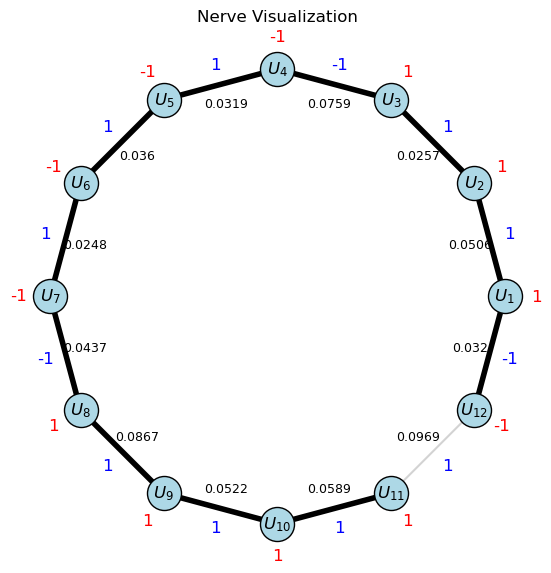

In [7]:
fig = bundle.show_circle_nerve()
plt.show()

Now, show a sample of coordinatized patches from the dataset:

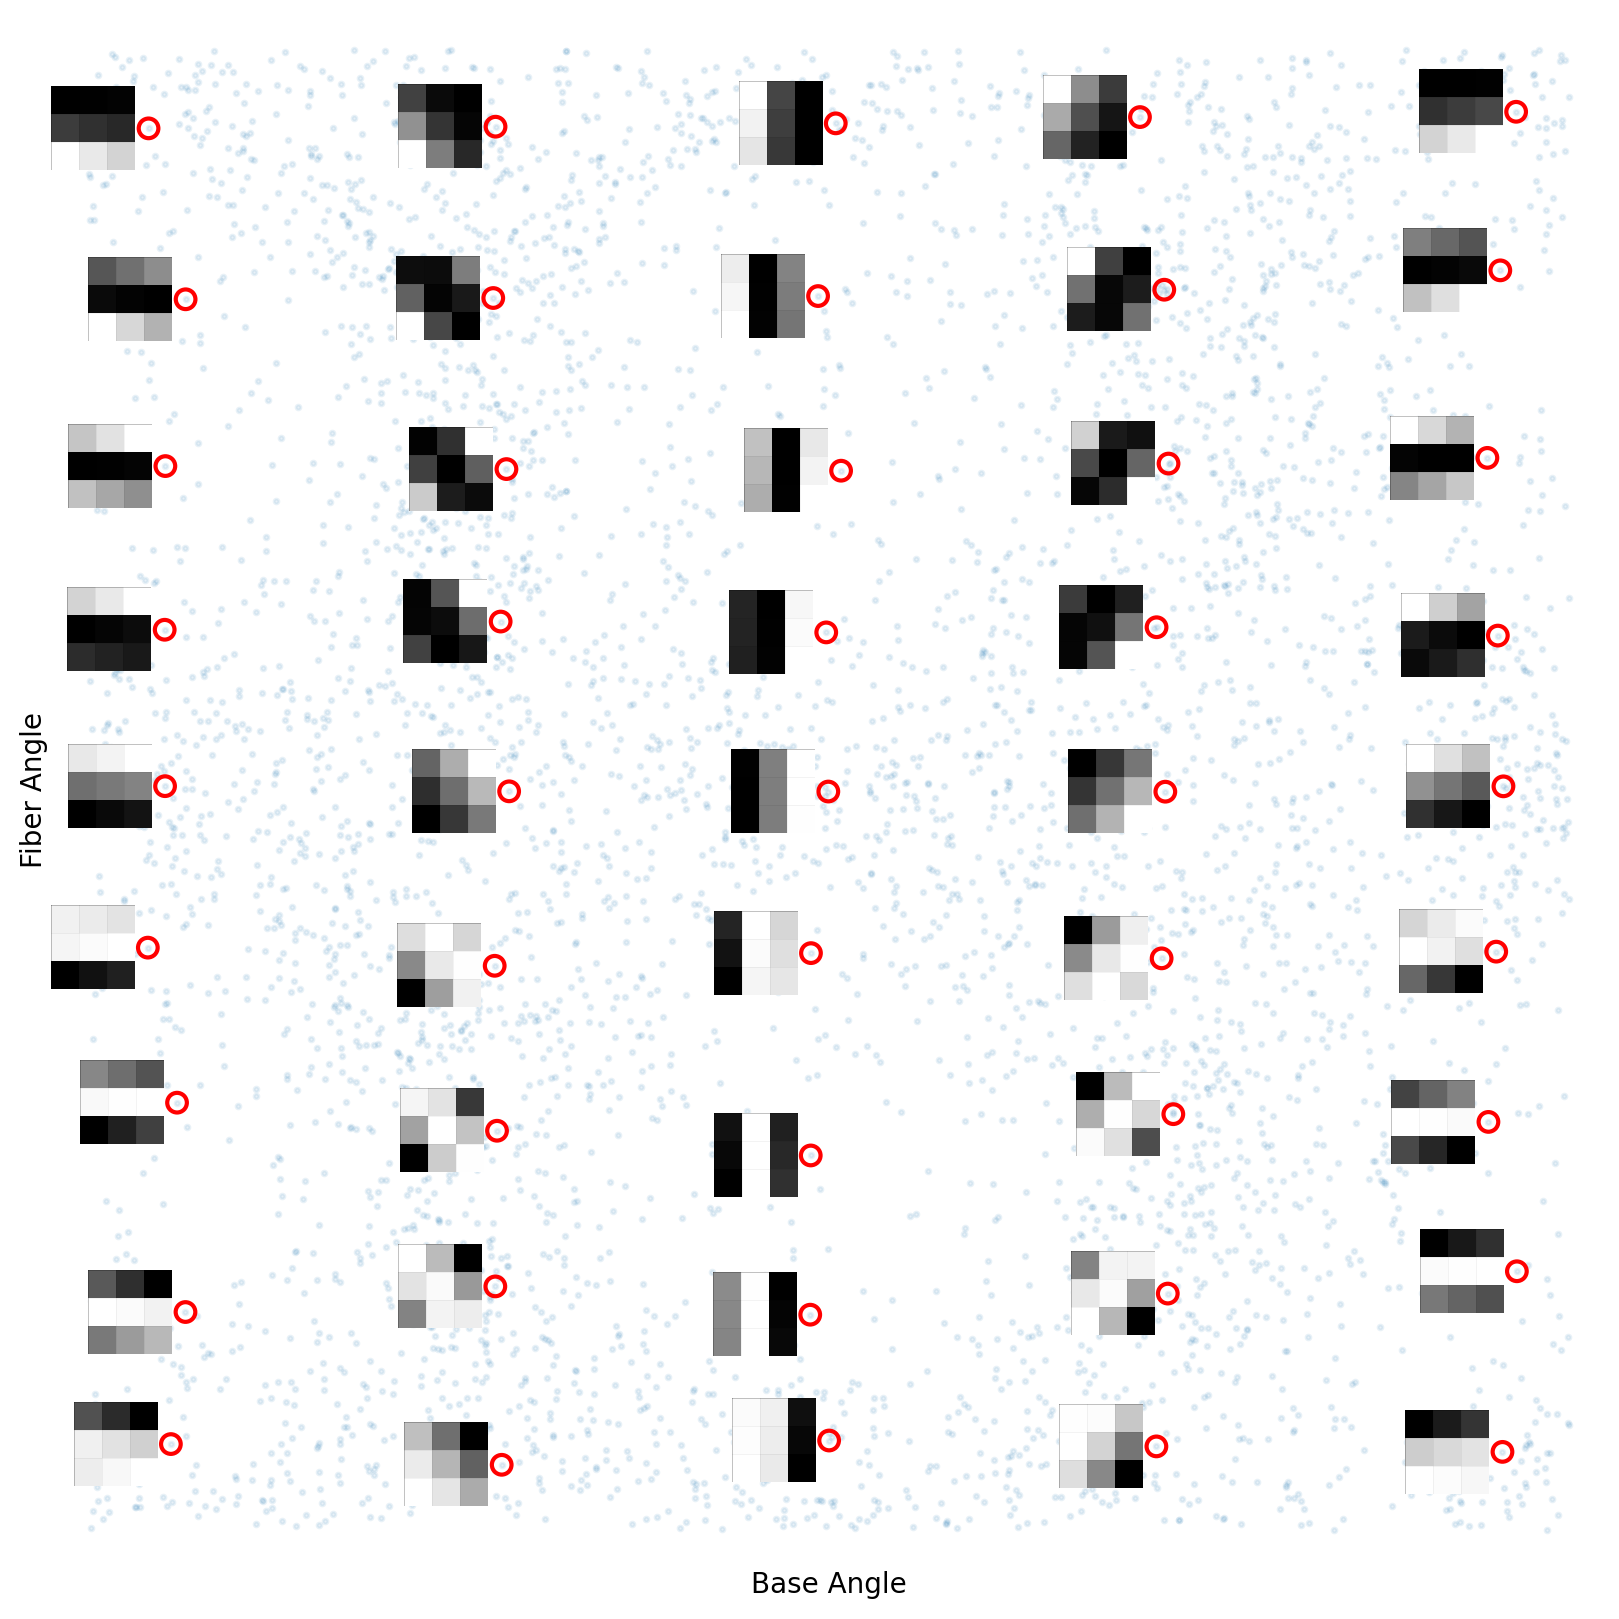

In [9]:
coords = np.column_stack([base_angles.reshape(-1,1), global_triv_result.reshape(-1,1)])

per_row = 5
per_col = 9

fig = cb.scatter_lattice_vis(data, 
                          coords, 
                          patch_vis, 
                          per_row = per_row, 
                          per_col = per_col, 
                         )
plt.show()


Notice the abrupt reflection in the coordinates between columns 4 and 5 in the diagram above. Everywhere else, the coordinate system varies continuously, and the edges of the diagram roughly coincide. 